In [516]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

class Particle():
    def __init__(self, t = 0, p = np.zeros(2), v = np.zeros(2), v_max = 1000, a_max = 6):
        """ Creates a particle
        
        """
        
        self.t = t
        
        self.p = p
        
        self.v = v
        
        self.v_min, self.v_max = 0, v_max
        self.a_min, self.a_max = 0, a_max

        
        self.history = pd.DataFrame(columns=['t','px','py','vx','vy','ax','ay'])
        
        self.vdHistory = pd.DataFrame(columns=['t','vdx','vdy'])
        
        self.p_target = np.zeros(2)
        
        self.p_targetHistory = pd.DataFrame(columns = ['t', 'dist'])
        
    def update(self, a = np.zeros(2), dt = 1):
        """Updates the position and velocity of the particle. 
        Overwrites the current values.
        Stores new values in history
        
        Parameters
        __________
        a : numpy 2x1 vector, optional
            acceleration vector of the particle (default is [0,0])
            
        dt: float, optional
            time step (default is 1)
                
        """
        #store in history
        history = {'t': self.t,
                   'px': self.p[0],
                   'py': self.p[1],
                   'vx': self.v[0],
                   'vy': self.v[1],
                   'ax': a[0],
                   'ay': a[1]}
        
        self.history = self.history.append(history,ignore_index=True)
        
        #update
        self.t += dt
        self.p = self.p + self.v * dt + 0.5 * a * dt**2
        self.v = self.v +      a * dt
        
        
        
        return
    
    def P_controller(self, vd = None, k = 1, update=True, dt=1):
        """ Determines the acceleration based on a proportional controller.
        If update is true, it also performs the update
        
        Parameters
        __________
        vd : numpy 2x1 vector, optional
            desired velocity (default is current velocity vector)
        
        k  : float, optional
            proportional controller gain (default is 1)
            
        update: boolean
            if true, state will be updated (default is True)
        
        dt : float
            simulation time step, only needed if update is true (default is 1)
        
        Returns
        _______
        a  : numpy 2x1 vector
            acceleration of the particle
        
        """
        
        if vd is None:
            vd = self.v
        
        #store vd
        self.vdHistory = self.vdHistory.append({'t':self.t, 'vdx': vd[0],'vdy': vd[1]}, ignore_index= True)
        
        #proportional gain
        a = k * (vd - self.v)
        
        if norm(a) > self.a_max:
            #cap based on max value
            a = (a/norm(a)) * self.a_max
                    
        if update:
            self.update(a = a, dt = dt)
        
        return a
    
    def target_spot(self, p_target = None, k = 1):
        """ Returns the targetting speed vector using a proportional controller on the distance.
        If no p_target is specified, the one stored for this particle is used.
        If a p_target is specified, the stored p_target is updated. 
        
        Parameters
        __________
        
        p_target: numpy 2x1, optional
            target destination (default is origin)
            
        k : float
            controller gain (default is 1)
        """
        
        if p_target is None:
            p_target = self.p_target
        else:
            self.p_target = p_target
            
        
        v_target = k*(p_target - self.p)
        
        v_target -= 0.4*self.v 
        
        if norm(v_target) > self.v_max:
            v_target = self.v_max * v_target/norm(v_target)
            
        self.p_targetHistory = self.p_targetHistory.append({'t': self.t, 'dist': norm(p_target - self.p)}, ignore_index = True)
            
        return v_target
    
    def repulsion(self, r,p_rep=1, r0 = 1):
        """Returns the repulsion velocity for this particle due to a particle at r
        
        implements half spring repulsion model
        
        Parameters
        __________
        r: numpy 2x1 vector
            position of repulsive object
        
        p_rep: float
            repulsion gain
        
        r0: float
            interaction range
        
        """
        
        rij = (self.p - r)
        
        if norm(rij) >= r0:
            vrep = np.zeros(2)
            return vrep
        else:
            vrep = p_rep * (r0 - norm(rij)) * rij/norm(rij)
            return vrep
        
        
        
        
    def plot_path(self, fig = None, ax = None, colored = True, *args, **kwargs):
        """ Plots the path of a particle
        
        Parameters
        _________
        colored: bool
            if true, the plot will be colored with time.
        
        """
        
        plt.plot(self.history.px,self.history.py,'k',alpha = 0.4)
        if colored:
            plt.scatter(self.history.px, self.history.py, c=self.history.t, marker='.',cmap='jet')

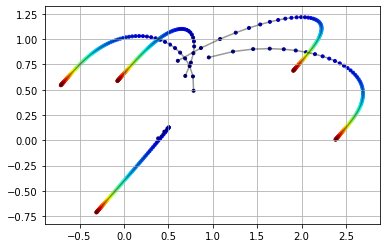

In [542]:
pList = [Particle(p = np.random.rand(2), v = 3*np.random.rand(2)) for i in range(5)]


for i in range(100):
    for p in pList:
        
        a = p.P_controller(vd = (1/(p.t+0.01)*(-0.25+0*np.random.rand(2))), dt = 0.1)
        #p.update(a = a, dt = 0.1)
        
plt.figure()

[p.plot_path(colored=True) for p in pList];

plt.grid()
plt.show()

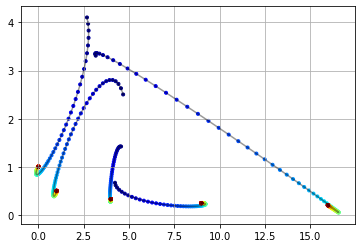

In [543]:
pList = [Particle(p = 5*np.random.rand(2), v = 3*(-0.5+np.random.rand(2))) for i in range(5)]

for i, p in enumerate(pList):
    p.p_target = np.array([i**2,1/(i+1)])

for i in range(100):
    for k,p in enumerate(pList):
        
        a = p.P_controller(vd = p.target_spot(), k = 1, dt = 0.1)
        #p.update(a = a, dt = 0.1)
        
plt.figure()

[p.plot_path(colored=True) for p in pList];

plt.grid()
plt.show()

In [ ]:
N = 5

pList = [Particle(p = 5*np.random.rand(2), v = 3*(-0.5+np.random.rand(2))) for i in range(N)]

for i, p in enumerate(pList):
    p.p_target = np.array([i**2,1/(i+1)])

for ti in range(100):
    for i,p in enumerate(pList):
        
        v_target  = p.target_spot()
        
        v_rep = sum([pList[i].repulsion(pList[j].p, p_rep = 0.1, r0 = 1) for j in range(N) if j is not i])
        
        v_d = v_target + v_rep
        
        a = p.P_controller(vd = v_d, k = 1, dt = 0.1)
        #p.update(a = a, dt = 0.1)
        
plt.figure()

[p.plot_path(colored=True) for p in pList];

plt.grid()
plt.show()

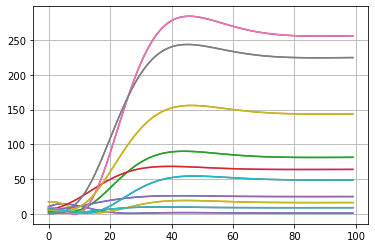

In [552]:
for i in range(N):
    for j in range(N):
        if i is not j:
            plt.plot((pList[i].history.px-pList[j].history.px)**2 +(pList[i].history.py-pList[j].history.py)**2)

plt.grid()


(-1, 5)

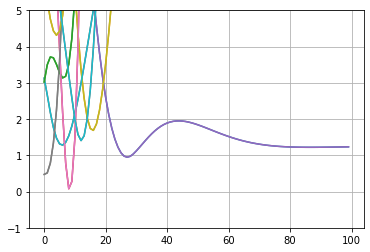

In [553]:
for i in range(N):
    for j in range(N):
        if i is not j:
            plt.plot((pList[i].history.px-pList[j].history.px)**2 +(pList[i].history.py-pList[j].history.py)**2)

plt.grid()
plt.ylim([-1,5])

In [550]:
[p.p for p in pList]

[array([-0.35053951,  1.29362173]),
 array([1.22259027, 0.28716611]),
 array([4.07259674, 0.29053478]),
 array([8.99054924, 0.25553538]),
 array([15.98607474,  0.20052374])]

In [515]:
pList[1].repulsion(np.array([4.42422294, 0.17547928]))

In [505]:
i=0
sum([pList[0].repulsion(pList[j].p,p_rep = 1, r0 = 1) for j in range(N) if j is not i])

0

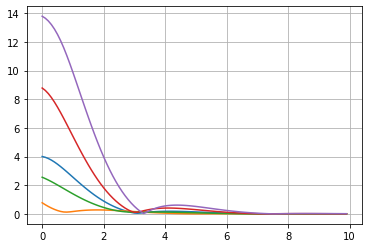

In [496]:
plt.figure()
[plt.plot(p.p_targetHistory.t, p.p_targetHistory.dist) for p in pList];
plt.grid()

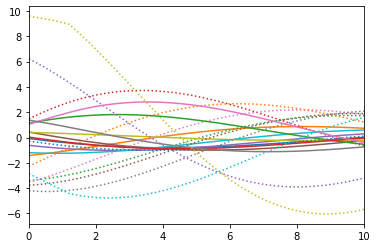

In [492]:
plt.figure()
for p in pList:
    plt.plot(p.history.t, p.history.vx)
    plt.plot(p.history.t, p.history.vy)
    plt.plot(p.vdHistory.t, p.vdHistory.vdx,':')
    plt.plot(p.vdHistory.t, p.vdHistory.vdy,':')
    
#plt.ylim([-3,3]);
plt.xlim([0,10]);

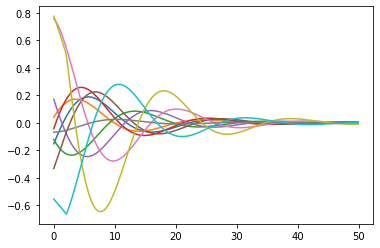

In [464]:
plt.figure()
for p in pList:
    plt.plot(p.history.t, p.history.ax)
    plt.plot(p.history.t, p.history.ay)

(-5, 5)

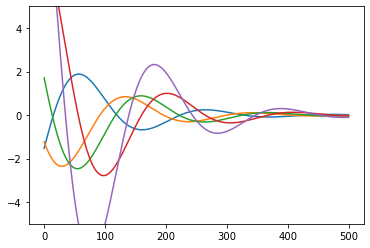

In [465]:
[plt.plot(p.vdHistory.vdx-p.history.vx) for p in pList]
plt.ylim([-5,5])

In [337]:
fig = None
ax = None

In [255]:
if fig == None:
    fig = plt.figure()
if ax == None:
    ax = fig.add_subplot()


points = np.array([p.history.px, p.history.py]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)



range_norm = plt.Normalize(p.history.t.min(), p.history.t.max())
# Create a continuous norm to map from data points to colors
lc = LineCollection(segments, cmap='viridis', norm=range_norm)
# Set the values used for colormapping
lc.set_array(p.history.t)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=ax)
#ax.set_xlim(.min(), x.max())
#ax.set_ylim(-1.1, 1.1)
plt.show()

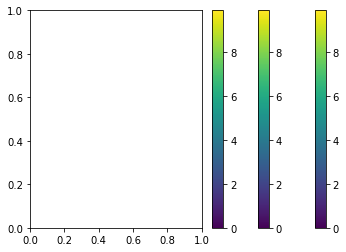

In [256]:
fig

In [245]:
plt.show()

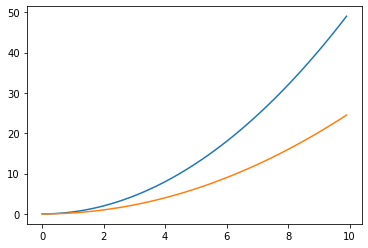

In [193]:
plt.figure;
plt.plot(p.history.t, p.history.px)
plt.plot(p.history.t, p.history.py)

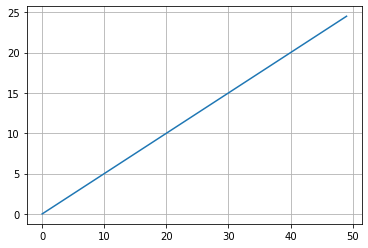

In [196]:
plt.figure
plt.plot(p.history.px,p.history.py)
plt.grid()

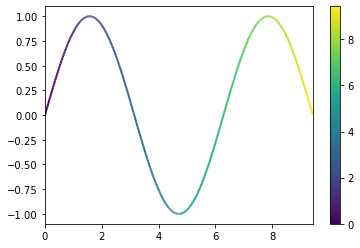

In [226]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx =  np.sqrt(x**2) #np.cos(0.5 * (x[:-1] + x[1:]))

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)


fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
norm = plt.Normalize(dydx.min(), dydx.max())
# Create a continuous norm to map from data points to colors
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)
axs.set_xlim(x.min(), x.max())
axs.set_ylim(-1.1, 1.1)
plt.show()

In [211]:

axs.add_collection(lc)


In [221]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

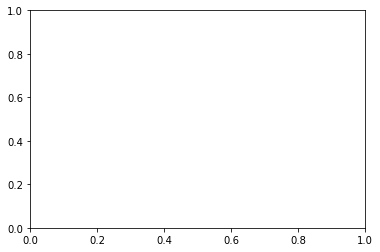

In [222]:
ax = plt.axes()

In [224]:
ax.add_collection(lc)

RuntimeError: Can not put single artist in more than one figure